Loading Iris dataset...
Training classifier from scratch...

--- Results for From-Scratch Classifier ---
Accuracy: 93.33%
Confusion Matrix:
 [[15  0  0]
 [ 0 14  1]
 [ 0  2 13]]
---------------------------------------------
Generating graphical representation...


/tmp/ipython-input-131724265.py:150: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[incorrect_mask, 0], X_test[incorrect_mask, 1],


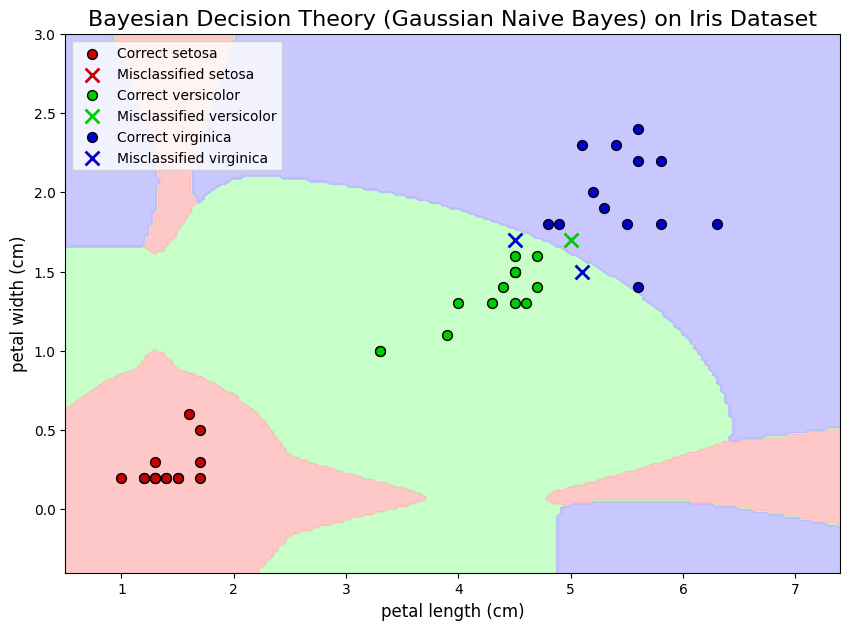

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

# --------------------------
# 1. Gaussian Naive Bayes Classifier (From Scratch)
# --------------------------
class GaussianNaiveBayes:
    """
    Implements Gaussian Naive Bayes based on Bayesian Decision Theory.
    Assumes features are conditionally independent (Naive) and
    normally distributed (Gaussian).
    """

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Calculate mean, variance, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            # Prior P(w_i) is the frequency of the class
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def _pdf(self, class_idx, x):
        """
        Calculate 1D Gaussian Probability Density Function (Likelihood of one feature)
        P(x_j | w_i)
        """
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        # Add a small epsilon to avoid division by zero if variance is zero
        return numerator / (denominator + 1e-9)

    def _predict_sample(self, x):
        """
        Predict the class for a single sample x using Bayesian Decision Rule.
        Finds argmax_i P(w_i | x) = argmax_i [ log(P(w_i)) + sum(log(P(x_j | w_i))) ]
        """
        posteriors = []

        for idx, c in enumerate(self._classes):
            # Log of the prior P(w_i)
            prior = np.log(self._priors[idx])

            # Sum of the logs of the likelihoods P(x_j | w_i) for all features j
            # We use logs for numerical stability (avoids multiplying many small numbers)
            likelihoods = self._pdf(idx, x)
            class_conditional = np.sum(np.log(likelihoods + 1e-9)) # Add epsilon for log(0)

            # Posterior probability (proportional to)
            posterior = prior + class_conditional
            posteriors.append(posterior)

        # Decision: return the class with the highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def predict(self, X):
        """Predict the class for a set of samples X."""
        y_pred = [self._predict_sample(x) for x in X]
        return np.array(y_pred)

# --------------------------
# 2. Load and Prepare Data
# --------------------------
print("Loading Iris dataset...")
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
feature_names = iris.feature_names

# For visualization, we'll only use two features:
# Petal Length (index 2) and Petal Width (index 3)
# These two features provide the best class separation.
X_vis = X[:, [2, 3]]
feature_names_vis = [feature_names[2], feature_names[3]]

# Split the 2-feature data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_vis, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------
# 3. Train and Evaluate Our Classifier
# --------------------------
print("Training classifier from scratch...")
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)

# Print results
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\n--- Results for From-Scratch Classifier ---")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", cm)
print("-" * 45)


# --------------------------
# 4. Graphical Representation (Decision Boundaries)
# --------------------------
print("Generating graphical representation...")

# We need a meshgrid to plot the decision boundaries
x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for every point on the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = nb_classifier.predict(grid_points)
Z = Z.reshape(xx.shape)

# Setup plot
plt.figure(figsize=(10, 7))
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ['#CC0000', '#00CC00', '#0000CC']

# Plot the decision boundaries
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

# Plot the test points
# We plot misclassified points with a black 'x'
for i, c in enumerate(np.unique(y_test)):
    # Plot correctly classified points
    correct_mask = (y_test == c) & (y_pred == c)
    plt.scatter(X_test[correct_mask, 0], X_test[correct_mask, 1],
                c=cmap_bold[i], label=f'Correct {target_names[c]}',
                edgecolors='k', s=50)

    # Plot incorrectly classified points
    incorrect_mask = (y_test == c) & (y_pred != c)
    plt.scatter(X_test[incorrect_mask, 0], X_test[incorrect_mask, 1],
                c=cmap_bold[i], label=f'Misclassified {target_names[c]}',
                marker='x', s=100, linewidth=2, facecolors='none', edgecolors='k')

plt.title("Bayesian Decision Theory (Gaussian Naive Bayes) on Iris Dataset", fontsize=16)
plt.xlabel(feature_names_vis[0], fontsize=12)
plt.ylabel(feature_names_vis[1], fontsize=12)
plt.legend()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()